# Spatial Interpolation

<img src="images/interpol.png" width=500 />

Spatial interpolation is the process of using observations with known values to estimate values at unkown locations. For example if we have precipitation data from different weather stations and we want to create a continous map for the entire area. Fortunatley in this case we can generally safely assume that values at nearby locations will be similar (spatial autocorrelation).

Because of high cost and limited resources, data collection is usually conducted only in a limited number of selected point locations. In GIS, spatial interpolation of these points can be applied to create a raster surface with estimates made for all raster cells.The results of the interpolation analysis can then be used for analyses that cover the whole area and for modelling.

There are many interpolation tools available, but these tools can usually be grouped into two categories: 

- deterministic: using mathematical functions, based on either the extent of similarity (IDW) or the degree of smoothing (RBF)
- geostatistical: use both mathematical and statistical methods to predict values at all locations within region of interest and to provide probabilistic estimates of the quality of the interpolation based on the spatial autocorrelation among data points

## Example: Temperature in Burkina Faso

In this example we will take temperature data from different weather stations and try to interpolate the missing data in order to create a map showing the mean temperature in some western african countries for 2019. Station data is derived from the GSOD (Global Surface Summary of the Day) dataset. 
Global Surface Summary of the Day is derived from The Integrated Surface Hourly (ISH) dataset. The ISH dataset includes global data obtained from the USAF Climatology Center, located in the Federal Climate Complex with NCDC. The latest daily summary data are normally available 1-2 days after the date-time of the observations used in the daily summaries. 



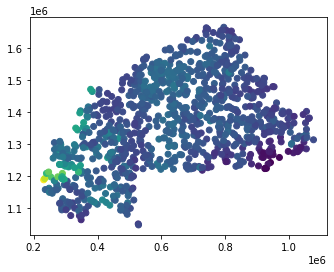

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt

#ws = gpd.read_file('Data/vector/ws.shp')
elevation = gpd.read_file('Data/vector/dem/ElevationData.shp')
elevation.plot(column='SRTM30mBur')
region = gpd.read_file('Data/vector/bfa.shp')

#region = gpd.read_file('Data/vector/reg.shp')
#ws

In [19]:
ws = ws.round(6)
ws['coords'] = elevation['geometry'].apply(lambda x: x.representative_point().coords[:])
ws['coords'] = [coords[0] for coords in elevation['coords']]
elevation.plot(figsize=(10,10))
for idx, row in elevation.iterrows():
    plt.annotate(s=row['mean_temp'], xy=row['coords'],
                 horizontalalignment='left')

KeyError: 'coords'

In [22]:
import mplleaflet
%matplotlib inline
ax = elevation.plot(column='SRTM30mBur', colormap='RdBu_r')
region.plot(ax=ax)
mplleaflet.display(fig=ax.figure, tiles='cartodb_positron')

/home/sth02bh/.local/lib/python3.8/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Deterministic methods

In this course we will have a look at 2 deterministic methods: 
- Thiessen polygons 
- Inverse Distance Weighted

## Voronoi polygons

A Voronoi diagram, also called Thiessen polygons or Dirichlet decomposition, is a decomposition of space into regions determined by a given set of points in space, here called centers. Each region is defined by exactly one centre and includes all points of space which, in terms of Euclidean metrics, are closer to the centre of the region than to any other centre. Such regions are also called Voronoi regions. The Voronoi diagram is formed from all points that have more than one nearest centre and thus form the boundaries of the regions. 


<img src="images/voronoi.png" width=200 />

/home/sth02bh/.local/lib/python3.8/site-packages/geopandas/plotting.py:558: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


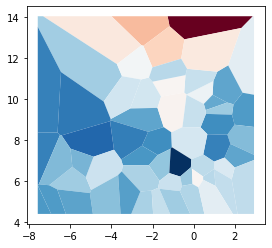

In [9]:
import numpy as np
from libpysal.cg.voronoi  import voronoi, voronoi_frames

x = ws['geometry'].apply(lambda x: x.x)
y = ws['geometry'].apply(lambda x: x.y)

data = np.column_stack((x, y))
region_df, point_df = voronoi_frames(data)
region_df['mean_temp'] = ws['mean_temp']
region_df.plot(column='mean_temp', colormap='RdBu_r')

<ipython-input-10-86eb3e55992e>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  vo_clip = gpd.clip(region_df,region)
/home/sth02bh/.local/lib/python3.8/site-packages/geopandas/plotting.py:558: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


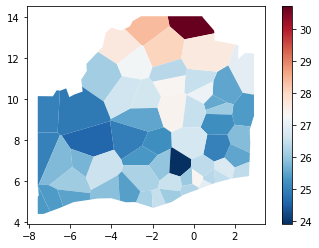

In [10]:
vo_clip = gpd.clip(region_df,region)
vo_clip.plot(column='mean_temp', colormap='RdBu_r', legend=True)

## IDW

Probably one of the oldest spatial prediction technique is the inverse distance interpolation. IDW is a simple non-statistical interpolation method and is based on the principle of spatial correlation - i.e. things that are closer to each other are more similar in value. IDW uses only the distance between the individual measuring points and the point to be calculated as the influencing factor for the interpolation, i.e. the greater the distance, the smaller the influence of the measuring point on the calculation of a value for a non-sampled location.

$$\hat{P} = \frac{\sum_{i=1}^n \frac{P_i}{d_i²}}{\sum_{i=1}^n\frac{1}{d_i²}}$$

The measure closest to the prediction location have more influence on the predicted value than those farther away. IDW assumes that each measurement influences the surrounding and that influence becomes weaker with increasing distance. The idea is give greater weights to observations close to the location we want to predict. With increasing distance to the observation the smaller weights are assigned, hence the name inverse distance weighted

<img src="images/idw_calc.png"  width=420 />

$$\hat{P} = \frac{\frac{10}{25²} + \frac{20}{15²} +\frac{30}{10²}}{\sum_{i=1}^n\frac{1}{25²}\frac{1}{15²}\frac{1}{10²}} = 25.24$$ 

In [24]:
import skspatial
import numpy as np

region = region.to_crs(elevation.crs)

In [25]:
ulc = (region.bounds.minx.min(),region.bounds.maxy.max())
lrc = (region.bounds.maxx.max(),region.bounds.miny.min())

In [29]:
res = 0.01
ml = skspatial.interp2d(elevation,'SRTM30mBur',res=res, ulc=ulc, lrc=lrc)
ml

In [37]:
%conda 

['WARNING: pip is being invoked by an old script wrapper. This will fail in a future version of pip.',
 'Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.',
 "To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.",
 'affine==2.3.0',
 'alembic==1.1.0.dev0',
 'altair==4.1.0',
 'altair-data-server==0.4.1',
 'altair-viewer==0.3.0',
 'appdirs==1.4.3',
 'apt-xapian-index==0.49',
 'apturl==0.5.2',
 'argcomplete==1.12.0',
 'arrow==0.15.7',
 'asciitree==0.3.3',
 'astroid==2.4.1',
 'attrs==19.3.0',
 'autopep8==1.5.2',
 'Babel==2.6.0',
 'backcall==0.1.0',
 'basemap==1.2.1',
 'bcrypt==3.1.7',
 'beautifulsoup4==4.9.1',
 'binaryornot==0.4.4',
 'bleach==3.1.4',
 'blinker==1.4',
 'bokeh==2.1.1',
 'boto==2.49.0',
 'branca==0.3.1',
 'Brlapi==0.7.0',
 'bs4==0.0.1',
 'cached-property==1.5.1',
 'cachetools==4.1.0',
 'caffeine==2.9.4',
 'Cartopy==0.18.0',
 'certifi==2020.4.5.1',
 'cftime==1.1.2',
 'chardet==3.0.4',
 'Click==7.0

3277588079335.5

In [30]:
array = ml.knn_2D(k=10, weights='distance')
array

array([[358.1342279 , 358.12623641, 358.11814627, ..., 259.7071762 ,
        259.70133033, 259.6955567 ],
       [358.14699056, 358.13901264, 358.13093541, ..., 259.69985062,
        259.69402039, 259.68826279],
       [358.15985349, 358.15188989, 358.14382634, ..., 259.6924536 ,
        259.68663975, 259.68089892],
       ...,
       [290.78011138, 290.75366988, 290.18906355, ..., 182.41966124,
        182.43688593, 182.45399544],
       [290.76003999, 290.19114665, 290.17458234, ..., 182.41156028,
        182.42868955, 182.4457053 ],
       [290.74050393, 290.17712845, 290.16047798, ..., 182.40357378,
        182.42060807, 182.43753047]])

<a list of 8 text.Text objects>

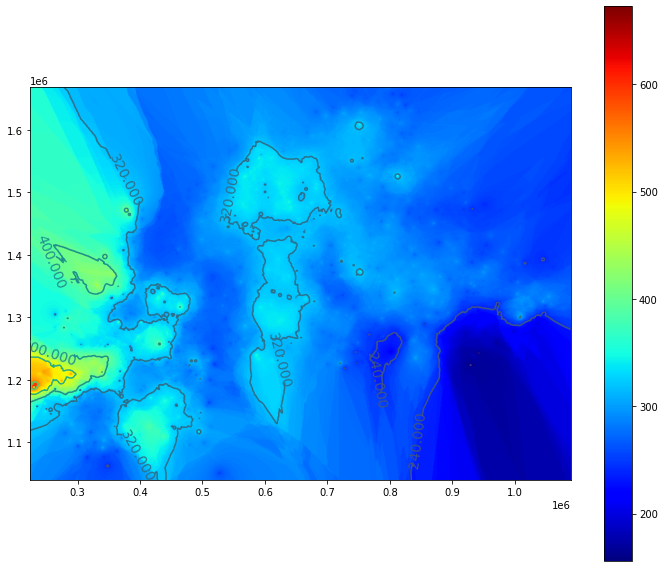

In [33]:
ax = ml.plot_image(array)
CS = plt.contour(np.flipud(array),extent=ml.extent)
#region.boundary.plot(ax=ax, color='red')
plt.clabel(CS,fontsize=14)


##  Statistical Approach 

## Trend Surfaces

This interpolation methods fits a polynomial surface by least-squares regression through the sample data points.The result is a surface that minimizes the variance of the surface in relation to the input values. In this section we will explore a 0th order, 1st order and 2nd order surface trend.

<img src="images/surface_trend.png" width=600 />

The first order surface polynomial is a flat plane whose formula is given by: 
$$Z = a + bX + cY$$

Adding a term to the mathematical formula allows us to add another bend in the plane.
- first-order polynomial (linear).
<img src="images/surface_trend1.png" width=150 />
- second-order polynomial (quadratic) 
<img src="images/surface_trend2.png" width=150 />
- third-order (cubic)
<img src="images/surface_trend3.png" width=150 />
- fourth-oder (quartic)
<img src="images/surface_trend4.png" width=150 />

In [5]:
import pandas as pd
import cartopy.crs as ccrs
import verde as vd

order = 5

ws['longitude'] = ws['geometry'].apply(lambda x: x.x)
ws['latitude'] = ws['geometry'].apply(lambda x: x.y)

coordinates = (ws.longitude.values, ws.latitude.values)
coordinates

trend = vd.Trend(degree=order)

.fit(coordinates, ws.mean_temp)

ws["trend"] = trend.predict(coordinates)
ws["residual"] = ws.mean_temp - ws.trend


In [6]:
grid = trend.grid(spacing=0.1, dims=["latitude", "longitude"])
grid

<xarray.Dataset>
Dimensions:    (latitude: 97, longitude: 106)
Coordinates:
  * longitude  (longitude) float64 -7.587 -7.487 -7.387 ... 2.733 2.833 2.933
  * latitude   (latitude) float64 4.417 4.517 4.617 4.717 ... 13.83 13.93 14.03
Data variables:
    scalars    (latitude, longitude) float64 24.97 24.98 24.98 ... 37.09 37.48
Attributes:
    metadata:  Generated by Trend(degree=5)

<ipython-input-7-ae83b3a7cc3d>:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


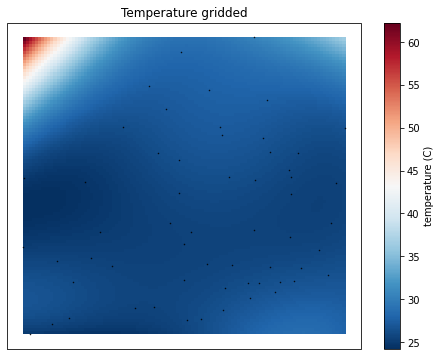

In [7]:
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("Temperature gridded")
ax.plot(*coordinates, ".k", markersize=1, transform=ccrs.PlateCarree())
tmp = ax.pcolormesh(
    grid.longitude,
    grid.latitude,
    grid.scalars,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp).set_label("temperature (C)")
plt.tight_layout()
plt.show()

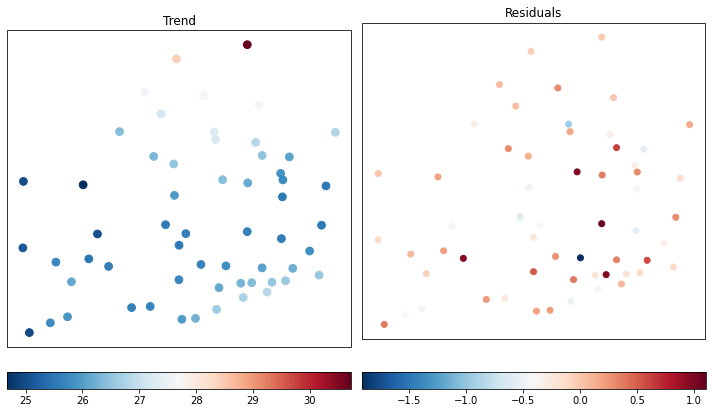

In [8]:
residuals = ws.mean_temp - ws.trend
fig, axes = plt.subplots(
    1, 2, figsize=(10, 6), subplot_kw=dict(projection=ccrs.Mercator())
)

ax = axes[0]
ax.set_title("Trend")
tmp = ax.scatter(
    ws.longitude,
    ws.latitude,
    c=ws.trend,
    s=60,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp, ax=ax, orientation="horizontal", pad=0.06)

ax = axes[1]
ax.set_title("Residuals")
tmp = ax.scatter(
    ws.longitude,
    ws.latitude,
    c=residuals,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp, ax=ax, orientation="horizontal", pad=0.08)
plt.tight_layout()
plt.show()


In [10]:
import numpy as np

train, test = vd.train_test_split(
    coordinates, ws.mean_temp, test_size=0.2, random_state=1,
)

trend = vd.Trend(degree=order).fit(*train)

test_values = np.array(list(test[1]))
prediction = trend.predict(test[0])

df = pd.DataFrame({'obs':test_values[0], 'pred':prediction})

correlation_matrix = np.corrcoef(test_values[0], prediction)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

0.7324338608563329

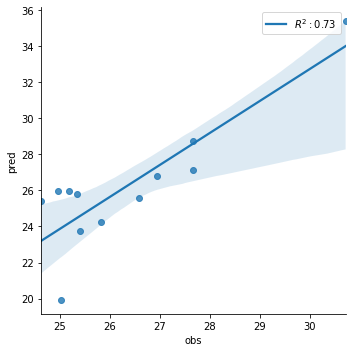

In [43]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats


p = sns.lmplot(x='obs',y='pred',data=df,
        line_kws={'label':"Linear Reg"}, legend=True)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_2 = r'$R^2:{0:.2f}$'.format(r_squared) 
L_labels[0].set_text(label_line_2)

In [12]:
scores = vd.cross_val_score(vd.Trend(degree=order), coordinates, ws.mean_temp, scoring=None)

print("k-fold scores:", scores)
print("Mean score:", np.mean(scores),)

TypeError: cross_val_score() got an unexpected keyword argument 'scoring'

## Spline inerpolation

The spline method works a little bit like the trend surface. You can think of a rubber disc passing through the points, which is bent while the overall curvature of the surface is minimized. It adjusts a mathematical function according to a specified number of next input points as it passes through the reference points. This method is best suited for generating smoothly changing surfaces, e.g. heights, water levels or pollutant concentrations.

The basic form of the spline method with minimal curvature imposes the following two conditions on the interpolant:

   - The surface must pass exactly through the data points.
   - The surface must have minimal curvature. The total sum of the squares of the second derivative values of the surface, measured over all points of the surface, must be a minimum.

<img src="images/Spline_interpolation.png" width=600 />

In [45]:
coordinates = (ws.longitude.values, ws.latitude.values)
spline = vd.Spline().fit(coordinates, ws.mean_temp)
grid = spline.grid(spacing=0.1, dims=["latitude", "longitude"])

<ipython-input-46-ae83b3a7cc3d>:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


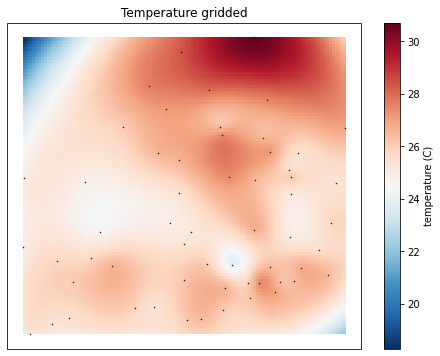

In [46]:
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("Temperature gridded")
ax.plot(*coordinates, ".k", markersize=1, transform=ccrs.PlateCarree())
tmp = ax.pcolormesh(
    grid.longitude,
    grid.latitude,
    grid.scalars,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp).set_label("temperature (C)")
plt.tight_layout()
plt.show()

In [47]:
train, test = vd.train_test_split(
    coordinates, ws.mean_temp, test_size=0.2, random_state=0,
)

spline = vd.Spline().fit(*train)

test_values = np.array(list(test[1]))
prediction = spline.predict(test[0])

df = pd.DataFrame({'obs':test_values[0], 'pred':prediction})

correlation_matrix = np.corrcoef(test_values[0], prediction)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

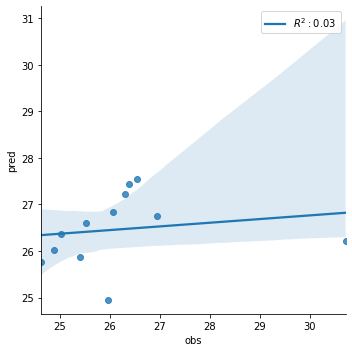

In [48]:
p = sns.lmplot(x='obs',y='pred',data=df,
        line_kws={'label':"Linear Reg"}, legend=True)

ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_2 = r'$R^2:{0:.2f}$'.format(r_squared) 
L_labels[0].set_text(label_line_2)

In [49]:
scores = vd.cross_val_score(vd.Spline(), coordinates, ws.mean_temp)
print("k-fold scores:", scores)
print("Mean score:", np.mean(scores))

k-fold scores: [-0.10038488  0.41596453 -2.91311662  0.33700494 -0.96407058]
Mean score: -0.6449205214517584


## Kriging

The Kriging method assumes that the distance or direction between reference points reflects a spatial correlation that can be used to explain variations on the surface. The Kriging tool fits a mathematical function to a specified number of points or all points within a specified radius to determine the output value for each location. 

"Kriging" is a multi-step process that includes: preliminary statistical analysis of the data, variogram modeling, creation of the surface, and (optionally) examination of a variance surface. In geostatistics the spatial correlation is modelled by the variogram instead of a correlogram or covariogram, largely for historical reasons. 

The main idea of kriging is that close sample points get more weight in a prediction to improve the estimate.  Kriging relies on the knowledge of some kind of spatial structure, which is modeled via the second-order properties, i.e.  variogram or covariance, of the underlying random function Z(x).Thus, the kriging process is best used when you know that the data has a spatially correlated distance or directional trend.Several forms of kriging interpolators exist (e.g. ordinary, universal and simple). A standard version of kriging is called ordinary kriging.

<img src="images/kriging.png" width=800 />

$$\gamma (h) = \frac{1}{2N(h)} * \sum_{i=1}^{N(h)}(Z(x_i) - Z(x_{i + h}))^2$$

<img src="images/variogram.png" width=500 />

   - Sill: The value at which the model first flattens out. 
   - Range: The distance at which the model first flattens out
   - Nugget: The value at which the semi-variogram (almost) intercepts the y-value

In [50]:
import numpy as np
import pandas as pd
import glob
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
import matplotlib.pyplot as plt

#from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch

region = gpd.read_file('Data/vector/reg.shp')

In [51]:
from shapely.ops import cascaded_union
boundary = cascaded_union(region.geometry)
xmin, ymin, xmax, ymax = boundary.bounds

In [52]:
xmin = xmin-0.01
xmax = xmax+0.01

ymin = ymin-0.01
ymax = ymax+0.01

grid_lon = np.linspace(xmin, xmax, 100)
grid_lat = np.linspace(ymin, ymax, 100)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 2
Full Sill: 2
Range: 7
Nugget: 0 



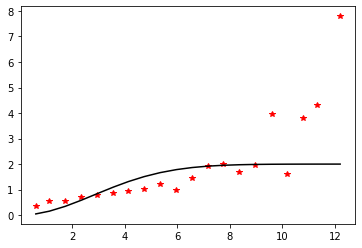

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

[[32.14302522523876 57.84435775270239 72.66405933930194 ...
  1495.6592667684074 1580.2504148855407 1650.8720100761507]
 [129.86536915684576 150.55328802367228 160.30243913611145 ...
  1361.6771694301658 1432.4751167174222 1488.5341144473332]
 [218.311209232427 234.3034058279119 239.29401876222394 ...
  1227.3006819426578 1283.933880100986 1325.0346021779278]
 ...
 [-2992.846778500955 -3088.864242460826 -3181.2714434966147 ...
  6007.2199271150785 6209.901925113578 6399.4672461770215]
 [-3099.2839039091036 -3197.1866079775436 -3291.3151188061456 ...
  6083.007889045148 6282.96229417277 6469.531338440139]
 [-3197.0530616117817 -3296.604450046489 -3392.244494689589 ...
  6141.208058055158 6337.674035096511 6520.527564479398]]


In [63]:
OK = OrdinaryKriging(ws.longitude,ws.latitude,ws.mean_temp, variogram_model='gaussian',variogram_parameters=[2, 7, 0],verbose=True, enable_plotting=True, nlags=20)
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)
print (z1)


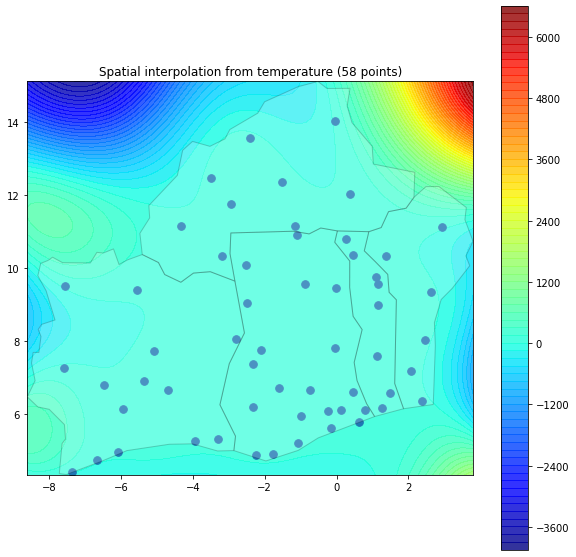

In [64]:
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat) 
fig, ax = plt.subplots(figsize=(10,10))

boundarygeom = region.geometry
contour = plt.contourf(xintrp, yintrp, z1,len(z1),cmap=plt.cm.jet,alpha = 0.8) 
plt.colorbar(contour)

region.plot(ax=ax, color='white', alpha = 0.2, edgecolor='black', zorder = 5)
npts = len(ws.longitude)

plt.scatter(ws.longitude, ws.latitude,marker='o',s=npts)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.xticks()
plt.yticks()

#Tempreture
plt.title('Spatial interpolation from temperature (%d points)' % npts)
plt.show()

In [65]:
np.random.seed(0)
test_indexes = np.random.choice(a=ws.index, size=int(np.round(len(ws.index.values)/4)))
train_indexes = [index for index in ws.index if index not in test_indexes]
ws_test = ws.loc[test_indexes,:].copy()
ws_train = ws.loc[train_indexes,:].copy()
print('Number of observations in training: {}, in test: {}'.format(len(ws_train), len(ws_test)))

Number of observations in training: 45, in test: 14


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 3.032011251255559
Full Sill: 3.224056786311109
Range: 12.093593841368975
Nugget: 0.1920455350555502 



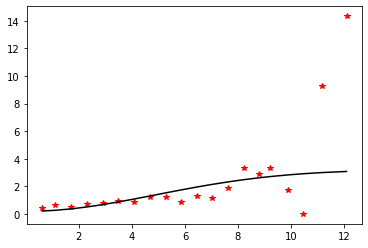

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [66]:
model = OrdinaryKriging(ws_train.longitude,ws_train.latitude,ws_train.mean_temp, variogram_model='gaussian', verbose=True, enable_plotting=True,nlags=20)
ws_test['prediction'] = model.execute(style='points', xpoints=ws_test.longitude, ypoints=ws_test.latitude )[0].data


In [67]:
df = pd.DataFrame({'obs':ws_test['mean_temp'] , 'pred':ws_test['prediction']})

correlation_matrix = np.corrcoef(ws_test['mean_temp'], ws_test['prediction'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
df

obs       pred
44  25.025000  25.108535
47  25.003704  25.306379
53  25.893333  25.767910
0   26.950000  26.093833
3   25.826667  25.611678
3   25.826667  25.611678
39  27.656667  27.857000
9   25.193333  25.768260
19  25.186207  25.719842
21  25.336667  25.701864
50  25.814286  25.351502
36  28.400000  29.068924
23  26.240000  25.864177
6   27.117241  26.455233

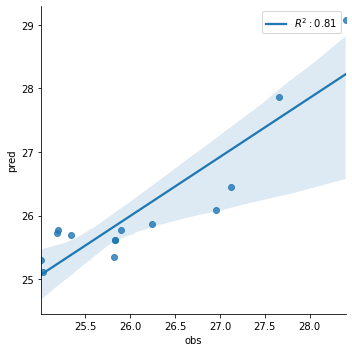

In [68]:
p = sns.lmplot(x='obs',y='pred',data=df,
        line_kws={'label':"Linear Reg"}, legend=True)
ax = p.axes[0, 0]
ax.legend()
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_2 = r'$R^2:{0:.2f}$'.format(r_squared) 
L_labels[0].set_text(label_line_2)

## Exercise

- Use the elevation point dataset and try to apply different interpolation methods
- Compare the different methods



# Literatur

Bivand, Roger S., et al. Applied spatial data analysis with R. Vol. 747248717. New York: Springer, 2008.

https://rspatial.org/raster/analysis/

https://mgimond.github.io/Spatial/introGIS.html

https://mmaelicke.github.io/scikit-gstat/tutorials/01_getting_started.html

https://github.com/WZBSocialScienceCenter/geovoronoi

https://github.com/rosskush/skspatial

https://github.com/fatiando/verde